In [1]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import Model

import cv2, numpy as np
import datetime
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [16]:
# Setting model's parameters
batch_size = 32
epochs = 20
lr = 0.00005
decay = lr / epochs
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)
seed = 7
np.random.seed(seed)

# Augmentation of Train set
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
                    '/content/gdrive/My Drive/Colab Notebooks/dataset/training_set/', # target directory
                    target_size=(224, 224), # all images will be resized to 224x224
                    batch_size=batch_size,
                    color_mode="rgb",
                    class_mode='categorical',
                    shuffle=True,
                    seed=seed)

# Augmentation of Validation set
dev_datagen = ImageDataGenerator(rescale=1./255)
dev_generator = dev_datagen.flow_from_directory(
                          '/content/gdrive/My Drive/Colab Notebooks/dataset/dev_set/', # target directory
                          target_size=(224, 224), # all images will be resized to 224x224
                          batch_size=batch_size,
                          color_mode="rgb",                    
                          class_mode='categorical',
                          shuffle=True,
                          seed=seed)

# Augmentation of Test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                          '/content/gdrive/My Drive/Colab Notebooks/dataset/test_set_full/', # target directory
                          target_size=(224, 224), # all images will be resized to 224x224
                          batch_size=1,
                          color_mode="rgb",
                          class_mode=None, # None, to return only the images.
                          shuffle=False, # False, because we need to yield the images in “order”, to predict the outputs and match them with their unique filenames.
                          seed=seed)

test_eval_generator = test_datagen.flow_from_directory(
                          '/content/gdrive/My Drive/Colab Notebooks/dataset/test_set/', # target directory
                          target_size=(224, 224), # all images will be resized to 224x224
                          batch_size=1,
                          color_mode="rgb",
                          class_mode='categorical',
                          shuffle=False,
                          seed=seed)

class_dictionary = train_generator.class_indices
print("Class-Index:", class_dictionary)

Found 205 images belonging to 3 classes.
Found 90 images belonging to 3 classes.
Found 90 images belonging to 1 classes.
Found 90 images belonging to 3 classes.
Class-Index: {'gallina': 0, 'mucca': 1, 'pecora': 2}


In [0]:
 # VGG16 Model
  
def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))   

    if weights_path:
        model.load_weights(weights_path) # Loading model's weights  
  
    return model

In [18]:
# Editing the VGG16 model
model = VGG_16('/content/gdrive/My Drive/Colab Notebooks/model/vgg16_weights_tf_dim_ordering_tf_kernels.h5') # Load the VGG16's weights

# Showing original Vgg16 Net
print(model.summary()) 
for i,layer in enumerate(model.layers):
    print(i,layer.name)

# Freezing all VGG16 layers
for layer in model.layers:
    layer.trainable = False

# Deleting last 5 layers (FC(4096) --> FC(4096) --> FC(1000))
model.pop()                                      
model.pop()   
model.pop()    
model.pop()   
model.pop() 

# Adding new top layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Compiling our model
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy', 'mae'])

# Showing our actual model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_27 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_28 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_29 (ZeroPaddi (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 112, 112, 128)     73856     
__________

In [19]:
# Training the model
timerStart = datetime.datetime.now()

step_size_train=train_generator.n // train_generator.batch_size
step_size_dev=dev_generator.n//dev_generator.batch_size
result = model.fit_generator(
        train_generator,
        steps_per_epoch= step_size_train,
        epochs=epochs,
        validation_data=dev_generator,
        validation_steps= step_size_dev)

# Printing the model's performance
timerStop = datetime.datetime.now()
print("Process ended in: ", (timerStop - timerStart).total_seconds())

print('Loss on train set:', round((result.history['loss'])[-1], 3))
print('Loss on validation set:', round((result.history['val_loss'])[-1], 3))

print('Accuracy on train set:', round((result.history['acc'])[-1], 3))
print('Accuracy on validation set:', round((result.history['val_acc'])[-1], 3))


Epoch 1/20
6/6 [==============================] - 4s 640ms/step - loss: 1.3662 - acc: 0.3490 - mean_absolute_error: 0.4430 - val_loss: 1.0759 - val_acc: 0.4062 - val_mean_absolute_error: 0.4286
Epoch 2/20
6/6 [==============================] - 2s 383ms/step - loss: 1.1117 - acc: 0.3858 - mean_absolute_error: 0.4135 - val_loss: 0.9398 - val_acc: 0.5690 - val_mean_absolute_error: 0.3999
Epoch 3/20
6/6 [==============================] - 2s 383ms/step - loss: 0.9040 - acc: 0.5417 - mean_absolute_error: 0.3669 - val_loss: 0.9362 - val_acc: 0.6034 - val_mean_absolute_error: 0.3987
Epoch 4/20
6/6 [==============================] - 2s 390ms/step - loss: 0.8073 - acc: 0.6459 - mean_absolute_error: 0.3514 - val_loss: 0.8555 - val_acc: 0.7188 - val_mean_absolute_error: 0.3751
Epoch 5/20
6/6 [==============================] - 2s 382ms/step - loss: 0.7261 - acc: 0.7265 - mean_absolute_error: 0.3233 - val_loss: 0.8227 - val_acc: 0.7241 - val_mean_absolute_error: 0.3594
Epoch 6/20
6/6 [==============

In [20]:
test_generator.reset()
y_pred = model.predict_generator(test_generator, len(test_generator.filenames), verbose = 1)
y_pred = np.argmax(y_pred, axis = 1) # for each image get the most probable class 

# Showing result
i = 0
performance = np.zeros((3))
for image in test_generator.filenames:
  print("file: ", image, "predicted:", y_pred[i], "actual:", i//30)
  if y_pred[i] == i//30:
    performance[i//30] +=1
  i+=1

# Estimate performance
for label, index in class_dictionary.items():
  print("Classe:", label, ":", performance[index], "/ 30 identificate correttamente (", round(performance[index]/30*100, 3), "% )")
print("Overall Accuracy:", round(np.sum(performance, axis=0) / len(test_generator.filenames), 3))

90/90 [==============================] - 3s 29ms/step
file:  test/test_01.jpeg predicted: 0 actual: 0
file:  test/test_02.jpeg predicted: 2 actual: 0
file:  test/test_03.jpeg predicted: 0 actual: 0
file:  test/test_04.jpeg predicted: 0 actual: 0
file:  test/test_05.jpeg predicted: 0 actual: 0
file:  test/test_06.jpeg predicted: 0 actual: 0
file:  test/test_07.jpeg predicted: 1 actual: 0
file:  test/test_08.jpeg predicted: 2 actual: 0
file:  test/test_09.jpeg predicted: 0 actual: 0
file:  test/test_10.jpeg predicted: 0 actual: 0
file:  test/test_11.jpeg predicted: 0 actual: 0
file:  test/test_12.jpeg predicted: 1 actual: 0
file:  test/test_13.jpeg predicted: 0 actual: 0
file:  test/test_14.jpeg predicted: 0 actual: 0
file:  test/test_15.jpeg predicted: 1 actual: 0
file:  test/test_16.jpeg predicted: 1 actual: 0
file:  test/test_17.jpeg predicted: 0 actual: 0
file:  test/test_18.jpeg predicted: 0 actual: 0
file:  test/test_19.jpeg predicted: 0 actual: 0
file:  test/test_20.jpeg predicted

In [21]:
score = model.evaluate_generator(test_eval_generator, 90)

print(round(score[0], 3), 'loss')
print(round(score[1], 3), 'accuracy')

0.703 loss
0.689 accuracy


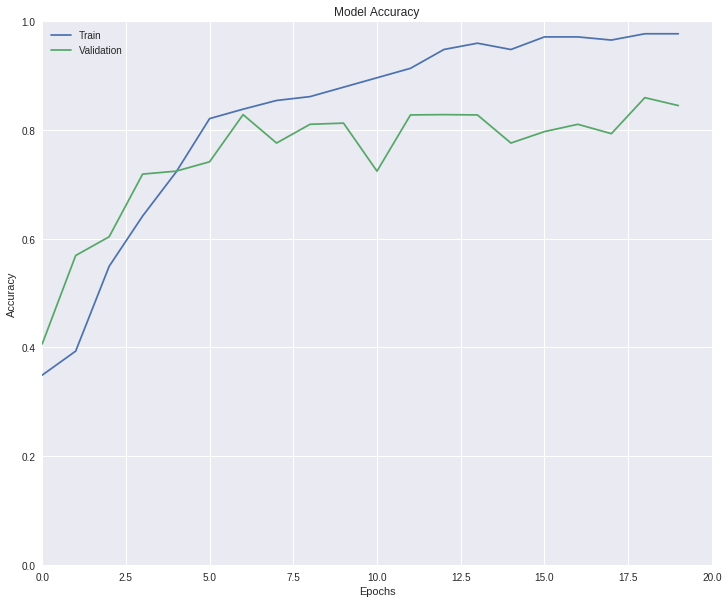

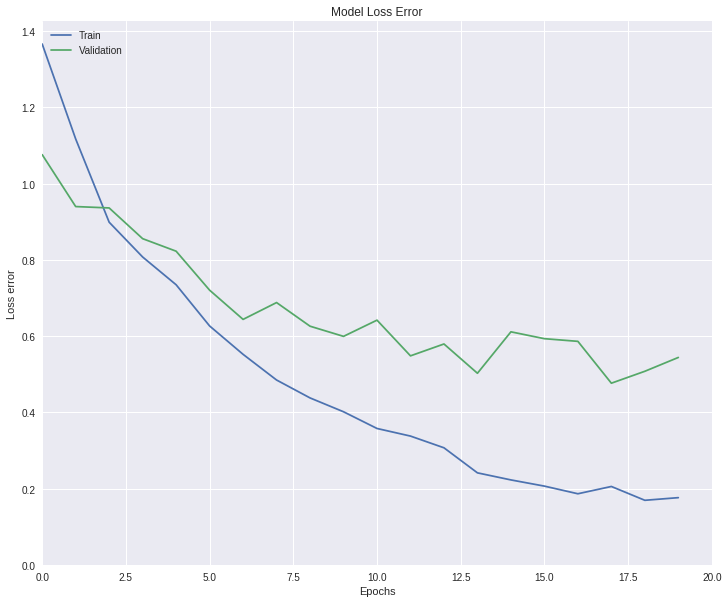

In [22]:
# Setting graph's size
plt.rcParams["figure.figsize"] = [12, 10]

# ------------------------ Accuracy graph ------------------------

# Loading datas
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('Model Accuracy')

# Setting graph
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
axes = plt.gca()
axes.set_xlim([0, epochs])
axes.set_ylim([0, 1])

# Showing graph
plt.show()

# ------------------------ Loss function graph ------------------------

# Loading datas
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Model Loss Error')

# Setting graph
plt.ylabel('Loss error')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
axes = plt.gca()
axes.set_xlim([0, epochs])
axes.set_ylim([0, None])

# Showing graph
plt.show()